# Applying WOfS Bitmasking

**Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only**

### General advice (delete this cell before submitting for review)

- When choosing a location for your analysis, **select an area that has data on both the `NCI` and `DEA Sandbox`** to allow your code to be run on both environments. 
For example, you can check this for Landsat using the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all products). 
As of September 2019, the `DEA Sandbox` has a single year of continental Landsat data for 2015-16, and the full 1987-onward time-series for three locations (Perth WA, Brisbane QLD, and western NSW).
- When writing in Markdown cells, start each sentence is on a **new line**.
This makes it easy to see changes through git commits.
- Use Australian English in markdown cells and code comments.
- Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
- In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case, seperate words with spaces, and where possible re-use existing tags.
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


### Background
WOfS shows water observed for every Landsat-5, Landsat-7 and Landsat-8 image across Australia (excluding External Territories) for the period of 1986 to present. **UPDATE this**  _The dataset is updated on as as-needs basis and is expected to increase in update frequency in the future so that as a satellite acquires data, it will automatically be analysed for the presence of water and added to the WOfS product in near real time.}_

Data is provided as Water Observation Feature Layers (WOFLs), in a 1 to 1 relationship with the input satellite data. Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

### Description
_description of the notebook_
This notebook explains both the structure of the WOFLs, and how this can be used for powerful and flexible masking.

The data for WOFLs is stored as a bit field. Each bit represents the presence/absence of a particular feature, where multiple bits can be set simultaneously. Whilst this can initially be confusing, once understood it provides significant flexibility in the way the product is used. 

### Technical details
* **Products used:** 
[`wofs_albers`](https://explorer.sandbox.dea.ga.gov.au/wofs_albers),
[`ga_ls8c_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3/2016),

* **Analyses used:** 
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook

## Getting started
Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [92]:
%matplotlib inline

import datacube
from datacube.storage import masking
import sys

sys.path.append("../Scripts")
from dea_plotting import rgb


### Connect to the datacube
Give your datacube app a unique name that is consistent with the purpose of the notebook.

In [5]:
dc = datacube.Datacube(app="Applying_WOfS_bitmasking")

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:
* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


In [3]:
param_name_1 = "example_value"
param_name_2 = "example_value"

## Load Data


In [89]:
# Pick your area of interest
x = (153.18, 153.38)
y = (-29.35, -29.55)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2018-01-01', '2018-01-20'),
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

In [108]:
# Load some wofs data
wofls = dc.load(product = 'wofs_albers', **query)

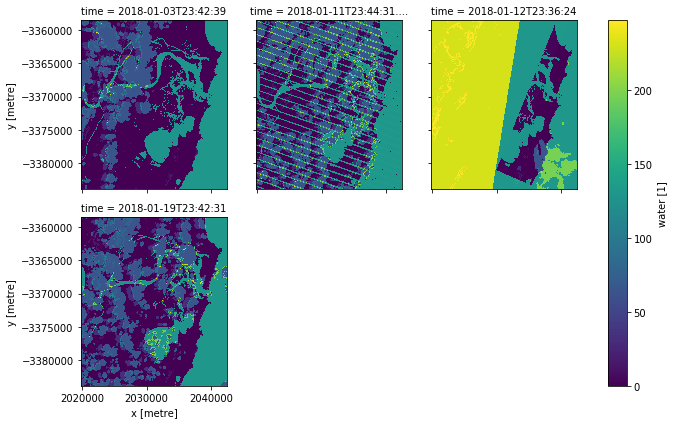

In [107]:
wofls.water.plot(col='time', col_wrap=3)

### Understanding WOFL structure

In [51]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls)
flags['bits'] = flags['bits'].astype(str)
flags.sort_values(by="bits")


,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/unde...
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",terrain shadow or low solar angle
high_slope,4,"{'0': False, '1': True}",High slope
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},No water detected
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


## Masking 
Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [6]:
# Load something to mask


## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [13]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)